# Obliczanie pierwiastków wielomianów w postaci

$f(x) = ax^3 + bx^2 + cx + d,\quad a,b,c,d \in R$


Zaczniemy od dodania potrzebnych biblotek pozwalających nam zdefiniować wielomiany w języku Julia oraz
rysować potrzebne wykresy

In [179]:
using Polynomials
using Plots

Zdefinijumy sobie przykładowy wielomian: $x^3 + x^2 + x + 1$ i narysujmy jego wykres.

In [180]:
f = Polynomial([1,1,1,1])

Polynomial(1 + x + x^2 + x^3)

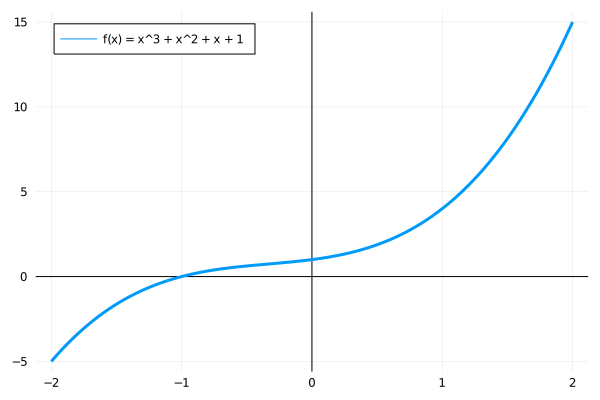

In [181]:
default(framestyle = :zerolines)
plot(f, -2, 2, label = "f(x) = x^3 + x^2 + x + 1", linewidth = 3, legend = :topleft)

### Obliczanie wartości funkcji i pochodnych

Potrzebujemy sprawnego i szybkiego algorytmu do obliczania wartości naszych wielomianów oraz ich pochodnych pierwszego stopnia. Do tego użyjemy rozszerzonego schematu Hornera danego algorytmem:

In [182]:
# Funkcja dla danej funkcji f i argumentu x zwróci parę (f(x0), f'(x0)).

function Horner(polynomial, x)
    n = length(polynomial) - 1
    
    f  = polynomial[n]
    ∂f = 0
    
    for i = n - 1:-1:0
        ∂f = f + x * ∂f
        f  = polynomial[i] + x * f
    end
    
    return f, ∂f
end

Horner (generic function with 1 method)

Sprawdźdmy poprawność działania algorytmu dla kilku przykładowych punktów

In [183]:
using Printf

println("Dla x = 0: ", Horner(f, 0))
println("Dla x = 2: ", Horner(f, 2))
println("Dla x = 4: ", Horner(f, 4))

Dla x = 0: (1, 1)
Dla x = 2: (15, 17)
Dla x = 4: (85, 57)


# Metoda Newtona

Poniżej znajduje się zaimplementowany algorytm metody Newtona

In [184]:
# Funkcja dla danej funkcji f, danego punktu startowego x0 zwróci pierwiastek z dokładnością do ε.
# Oczywiście tylko jeśli x0 będzie dostatecznie tego pierwiastka.
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Newton(f, x0, ε, M, print = false)
    v = Horner(f, x0)
    
    if (abs(v[1]) < ε)
        return x0
    end
    
    for i = 1:M
        x1 = x0 - v[1]/v[2]
        v = Horner(f, x1)
        
        rε = abs((x1 - x0)/x1)
        
        if print
            @printf("Iteracja: %d, x_i = %f, błąd bezwględny = %f\n", i, x1, rε)
        end
            
        if (abs(v[1]) < ε)
            return x1
        end
        
        x0 = x1
    end
    
    return x0
end

Newton (generic function with 2 methods)

Przetestujmy działanie algorytmu dla kilku punktów startowych dla naszej funkcji f.

In [185]:
Newton(f, 5, 1.0e-10, 20)

-1.0000000000000018

In [186]:
Newton(f, -6, 1.0e-10, 20)

-1.0000000000000009

In [187]:
Newton(f, 100, 1.0e-10, 20, true)

Iteracja: 1, x_i = 66.554055, błąd bezwględny = 0.502538
Iteracja: 2, x_i = 44.255989, błąd bezwględny = 0.503843
Iteracja: 3, x_i = 29.389435, błąd bezwględny = 0.505847
Iteracja: 4, x_i = 19.476583, błąd bezwględny = 0.508963
Iteracja: 5, x_i = 12.865175, błąd bezwględny = 0.513900
Iteracja: 6, x_i = 8.453046, błąd bezwględny = 0.521957
Iteracja: 7, x_i = 5.504251, błąd bezwględny = 0.535730
Iteracja: 8, x_i = 3.525977, błąd bezwględny = 0.561057
Iteracja: 9, x_i = 2.185383, błąd bezwględny = 0.613436
Iteracja: 10, x_i = 1.251379, błąd bezwględny = 0.746380
Iteracja: 11, x_i = 0.546928, błąd bezwględny = 1.288014
Iteracja: 12, x_i = -0.124919, błąd bezwględny = 5.378247
Iteracja: 13, x_i = -1.240055, błąd bezwględny = 0.899263
Iteracja: 14, x_i = -1.045616, błąd bezwględny = 0.185956
Iteracja: 15, x_i = -1.001988, błąd bezwględny = 0.043541
Iteracja: 16, x_i = -1.000004, błąd bezwględny = 0.001984
Iteracja: 17, x_i = -1.000000, błąd bezwględny = 0.000004


-1.0000000000155624

# Metoda bisekcji

Poniżej znajduje się zaimplementowany algorytm metody Newtona

In [188]:
# Funkcja, dla danej funkcji f, dwóch punktów startowych x0 <= x1 zwróci pierwiastek z dokładnością do ε.
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Bisection(f, x0, x1, ε, M, print = false)
    a = Horner(f, x0)[1]
    b = Horner(f, x1)[1]
    
    if (sign(a) == sign(b))
        return x0
    end
    
    for i = 1:M
        x2 = ((x0 + x1) / 2)
        
        v = Horner(f, x2)[1]
        
        if print
            @printf("Iteracja: %d, a = %f, b = %f, c = %f, f(c) = %f\n", i, x0, x1, x2, v)
        end
        
        if (abs(v) < ε)
            return x2
        end
        
        if (sign(a) != sign(v))
            x1 = x2
        else
            x0 = x2
        end
    end
    
    return x0
end

Bisection (generic function with 2 methods)

In [189]:
Bisection(f, -5, 5, 1.0e-10, 20)

-1.0000038146972656

In [190]:
Bisection(f, -50, 50, 1.0e-10, 20)

-1.0000228881835938

In [191]:
Bisection(f, -3, 16, 1.0e-10, 20, true)

Iteracja: 1, a = -3.000000, b = 16.000000, c = 6.500000, f(c) = 324.375000
Iteracja: 2, a = -3.000000, b = 6.500000, c = 1.750000, f(c) = 11.171875
Iteracja: 3, a = -3.000000, b = 1.750000, c = -0.625000, f(c) = 0.521484
Iteracja: 4, a = -3.000000, b = -0.625000, c = -1.812500, f(c) = -3.481689
Iteracja: 5, a = -1.812500, b = -0.625000, c = -1.218750, f(c) = -0.543671
Iteracja: 6, a = -1.218750, b = -0.625000, c = -0.921875, f(c) = 0.144520
Iteracja: 7, a = -1.218750, b = -0.921875, c = -1.070313, f(c) = -0.150860
Iteracja: 8, a = -1.070313, b = -0.921875, c = -0.996094, f(c) = 0.007782
Iteracja: 9, a = -1.070313, b = -0.996094, c = -1.033203, f(c) = -0.068648
Iteracja: 10, a = -1.033203, b = -0.996094, c = -1.014648, f(c) = -0.029729
Iteracja: 11, a = -1.014648, b = -0.996094, c = -1.005371, f(c) = -0.010800
Iteracja: 12, a = -1.005371, b = -0.996094, c = -1.000732, f(c) = -0.001466
Iteracja: 13, a = -1.000732, b = -0.996094, c = -0.998413, f(c) = 0.003169
Iteracja: 14, a = -1.000732,

-1.0000076293945312

# Metoda wyznczania pierwiastków wielomianów kwadratowych

Przed implementacją metody Bairstowa, potrzebuję mieć algorytm numerycznie poprawny, który znajdzie pierwiastki funkcji kwadratowej. Mogę to zrobić wyznaczając wyróżnik funkcji i używając istniejących wzorów Viete'a uważając, aby nie utracić cyfr znaczących.

In [192]:
# Funkcja, dla danej funkcji f zwróci jej pierwiastki zespolone

function solveQuadratic(f)
    a = f[2]
    b = f[1]
    c = f[0]
    
    x1 = 0
    x2 = 0
    
    Δ = b * b - 4 * a * c
    
    if (Δ > 0)
        
        if (b > 0)
            x1 = (-b - sqrt(Δ)) / (2 * a)
        else
            x1 = (-b + sqrt(Δ)) / (2 * a)
        end
        x2 = c / (a * x1)
            
    elseif (Δ == 0)        
        x1 = -b / (2 * a)        
        x2 = -b / (2 * a)
    else
        
        if (b > 0)
            x1 = (-b - sqrt(-Δ)*im) / (2 * a)
        else
            x1 = (-b + sqrt(-Δ)*im) / (2 * a)
        end
        x2 = c / (a * x1)
    end
    
    return x1, x2
end

solveQuadratic (generic function with 1 method)

In [193]:
solveQuadratic(Polynomial([-1,0,1]))

(1.0, -1.0)

In [194]:
solveQuadratic(Polynomial([1,0,1]))

(0.0 + 1.0im, 0.0 - 1.0im)

In [195]:
solveQuadratic(Polynomial([5,2,3]))

(-0.3333333333333333 - 1.247219128924647im, -0.3333333333333333 + 1.2472191289246473im)

In [196]:
roots(Polynomial([5,2,3]))

2-element Array{Complex{Float64},1}:
 -0.33333333333333337 - 1.2472191289246473im
 -0.33333333333333337 + 1.2472191289246473im

# Metoda Bairstowa

Poniżej znajduje się zaimplementowany algorytm metody Bairstowa.

In [197]:
# Funkcja, dla danej funkcji f, startowych przybliżeń v, u zwraca wszystkie pierwiastki 
# wielomianu trzeciego stopnia. Maksymalna liczba iteracji to M. 

function Bairstow(f, u, v, M)
    n = length(f)
    
    b = zeros(n)
    c = zeros(n)
    
    b[n] = f[n - 1]
    c[n - 1] = f[n - 1]
    
    for j = 1:M
        b[n-1] = f[n - 2] + u * b[n]
        for k = n - 2:-1:1
            b[k] = f[k - 1] + u * b[k + 1] + v * b[k + 2]
            c[k] = b[k + 1] + u * c[k + 1] + v * c[k + 2]
        end
        
        J = c[1] * c[3] - c[2] * c[2]
        u = u + (c[2] * b[2] - c[3] * b[1]) / J
        v = v + (c[2] * b[1] - c[1] * b[2]) / J
    end
    
    quadratic = Polynomial([-v, -u, 1])
    x1, x2 = solveQuadratic(quadratic)
    
    if (x1 != 0 && x2 != 0)
        x3 = -f[0] / (f[3] * x1 * x2)
    else
        x3 = -f[2] / v[3] - x1 - x2
    end
    
    return [x1, x2, x3]
end

Bairstow (generic function with 1 method)

In [198]:
Bairstow(f, 1, 1, 40)

3-element Array{Complex{Float64},1}:
 3.5578623851139984e-17 + 1.0im
 3.5578623851139984e-17 - 1.0im
                   -1.0 + 0.0im

In [199]:
roots(f)

3-element Array{Complex{Float64},1}:
    -1.0000000000000009 + 0.0im
 -7.771561172376096e-16 - 0.9999999999999998im
 -7.771561172376096e-16 + 0.9999999999999998im

In [200]:
Bairstow(f, -0.5, -0.5, 40)

3-element Array{Complex{Float64},1}:
 5.442873907761786e-17 + 1.0im
 5.442873907761786e-17 - 1.0im
                  -1.0 + 0.0im

# Testy numeryczne

Zaimplementowałem trzy różne metody szukania pierwiastków wielomianów trzeciego stopnia. Ponieważ metoda Newtona i bisekcji potrzebują mieć sensowne dane wejściowe, aby znaleźć chociaż jeden pierwiastek, to pokażę jak szybko i z jakim błędem są w stanie go znaleźć. Na początek kilka testów przygotowanych, a później kilka wielomianów wylosowanych za pomocą Julii.

Zdefiniowałem dwie funkcje testujące. Pierwsza porównuje zbieżność metody Newtona i bisekcji do jednego pierwiastka. Druga pokazuje zbieżność metody Bairnstowa do wszystkich pierwiastków.

In [201]:
# Wyświetla ilość cyfr znaczących

function Test1(f, x0, x1, ε, MaxM, zero)
    
    function significantDigits(x)
        return max(0, round(-log10(abs(zero - x))))
    end
    
    newton = zeros(MaxM)
    bisection = zeros(MaxM)
    
    for i = 1:MaxM
        newton[i] = significantDigits(Newton(f, x0, ε, i))
        bisection[i] = significantDigits(Bisection(f, x0, x1, ε, i))
    end
    
    default(framestyle = :zerolines)
    plot([newton, bisection], label = ["Newton" "Bisection"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)
end

Test1 (generic function with 1 method)

In [202]:
# Wyświetla ilość cyfr znaczących dla każdego pierwiastka

function Test2(f, u, v, MaxM, r1, r2, r3)
   
    function significantDigits(x)
        return max(0, round(-log10(abs(x))))
    end
    
    zero = roots(f)
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bairstow(f, u, v, i)
    
        x0[i] = significantDigits(abs(zero[r1] - b[1]))
        x1[i] = significantDigits(abs(zero[r2] - b[2]))
        x2[i] = significantDigits(abs(zero[r3] - b[3]))
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)
end

Test2 (generic function with 1 method)

### Test 1
##### $f(x) = -\frac{8}{5}x^3 + 2x^2 + 17x - 2$  

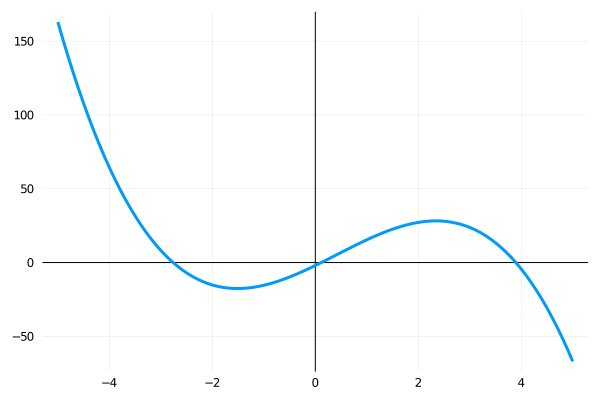

In [203]:
f = Polynomial([-2, 17, 2, -1.6])

default(framestyle = :zerolines)

M = 15
ε = 1.0e-10

plot(f, -5, 5, linewidth = 3, label = false)

In [204]:
roots(f)

3-element Array{Float64,1}:
 -2.7614849059271953
  0.11620606285418353
  3.89527884307301

In [205]:
Bairstow(f, 0.3, 0.3, M)

3-element Array{Float64,1}:
  3.89527884307301
 -2.7614849059271935
  0.1162060628541836

In [206]:
Newton(f, 1.7, ε, M, true)

Iteracja: 1, x_i = -0.799919, błąd bezwględny = 3.125214
Iteracja: 2, x_i = 0.458353, błąd bezwględny = 2.745202
Iteracja: 3, x_i = 0.118487, błąd bezwględny = 2.868379
Iteracja: 4, x_i = 0.116206, błąd bezwględny = 0.019626
Iteracja: 5, x_i = 0.116206, błąd bezwględny = 0.000004


0.11620606285419885

In [207]:
Bisection(f, -1, 3, ε, M, true)

Iteracja: 1, a = -1.000000, b = 3.000000, c = 1.000000, f(c) = 15.400000
Iteracja: 2, a = -1.000000, b = 1.000000, c = 0.000000, f(c) = -2.000000
Iteracja: 3, a = 0.000000, b = 1.000000, c = 0.500000, f(c) = 6.800000
Iteracja: 4, a = 0.000000, b = 0.500000, c = 0.250000, f(c) = 2.350000
Iteracja: 5, a = 0.000000, b = 0.250000, c = 0.125000, f(c) = 0.153125
Iteracja: 6, a = 0.000000, b = 0.125000, c = 0.062500, f(c) = -0.930078
Iteracja: 7, a = 0.062500, b = 0.125000, c = 0.093750, f(c) = -0.389990
Iteracja: 8, a = 0.093750, b = 0.125000, c = 0.109375, f(c) = -0.118793
Iteracja: 9, a = 0.109375, b = 0.125000, c = 0.117188, f(c) = 0.017078
Iteracja: 10, a = 0.109375, b = 0.117188, c = 0.113281, f(c) = -0.050879
Iteracja: 11, a = 0.113281, b = 0.117188, c = 0.115234, f(c) = -0.016906
Iteracja: 12, a = 0.115234, b = 0.117188, c = 0.116211, f(c) = 0.000085
Iteracja: 13, a = 0.115234, b = 0.116211, c = 0.115723, f(c) = -0.008411
Iteracja: 14, a = 0.115723, b = 0.116211, c = 0.115967, f(c) = 

0.1160888671875

#### Metoda bisekcji i Newtona

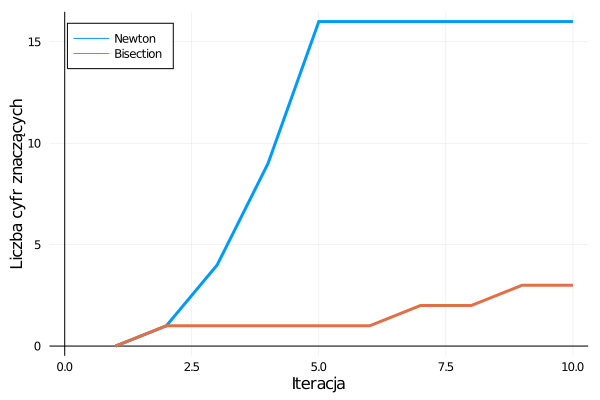

In [208]:
zero = roots(f)[2]
Test1(f, -1, 2.3, 1.0e-10, 10, zero)

#### Metoda Bairstowa

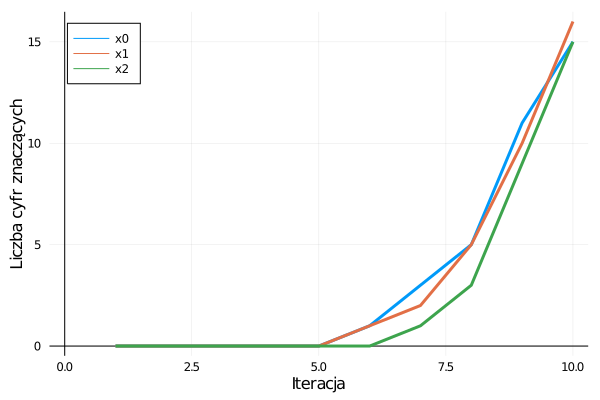

In [210]:
Test2(f, 0.1, 0.1, 10, 1, 2, 3)